In [852]:
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm
from matplotlib import colormaps
%matplotlib inline

## Goals
- Numerically show how a Debye-Waller factor arises in the Fourier domain as a function of thermal noise.
- Show where we can detect in the power spectra the fact that the average distance between atoms could stay constant, while the distances between atoms pairs increases with distance.
- Asymmetric position distribution.

In [98]:
def gen_lj_potential(temp, min_sep=0.6, max_sep=1.5, num_sep=200):
    seps = np.linspace(min_sep, max_sep, num_sep)
    energy = (0.5/seps**12 - 1/seps**6)
    min_energy = energy.min()
    probs = np.exp(-(energy-min_energy)/temp)
    probs /= probs.sum()
    return (seps, energy, probs)

def compute_fourier_of_1d_random_walker(temp, qs, num_atoms=10000):
    #steps = np.random.normal(loc=true_sep, scale=std_scale, size=num_atoms)
    seps, energy, probs = gen_lj_potential(temp, min_sep=0.6, max_sep=1.5, num_sep=200)
    
    steps = np.random.choice(seps, size=num_atoms, replace=True, p=probs)
    positions = np.cumsum(steps)
    #print(f"Average distance between neighboring atoms {steps.mean(): .8f} Angstroms.")

    distances = np.zeros(20)
    for n,d in enumerate(distances):
        nn = n+1
        distances[n] = np.mean(positions[nn:] - positions[:-nn] - nn)
        
    fourier = np.exp(2j*np.pi*positions[:,None]*qs[None,:]).sum(axis=0)
    return (steps.mean(), distances, fourier)

def gen_fourier_mp(in_temp, qs, trials_per_thread=1, num_threads = 24, num_atoms = 100000):
    p_compute_fourier_of_1d_random_walker = partial(compute_fourier_of_1d_random_walker, in_temp, qs, 
                                                num_atoms=num_atoms)

    with Pool(num_threads) as pool:
        results = [pool.apply_async(p_compute_fourier_of_1d_random_walker) for _ in range(trials_per_thread*num_threads)]
        output = [result.get() for result in results]
    
    steps = np.asarray([o[0] for o in output])
    distances = np.asarray([o[1] for o in output])
    fourier = np.asarray([o[2] for o in output]).sum(axis=0)
    return (steps, distances, fourier)

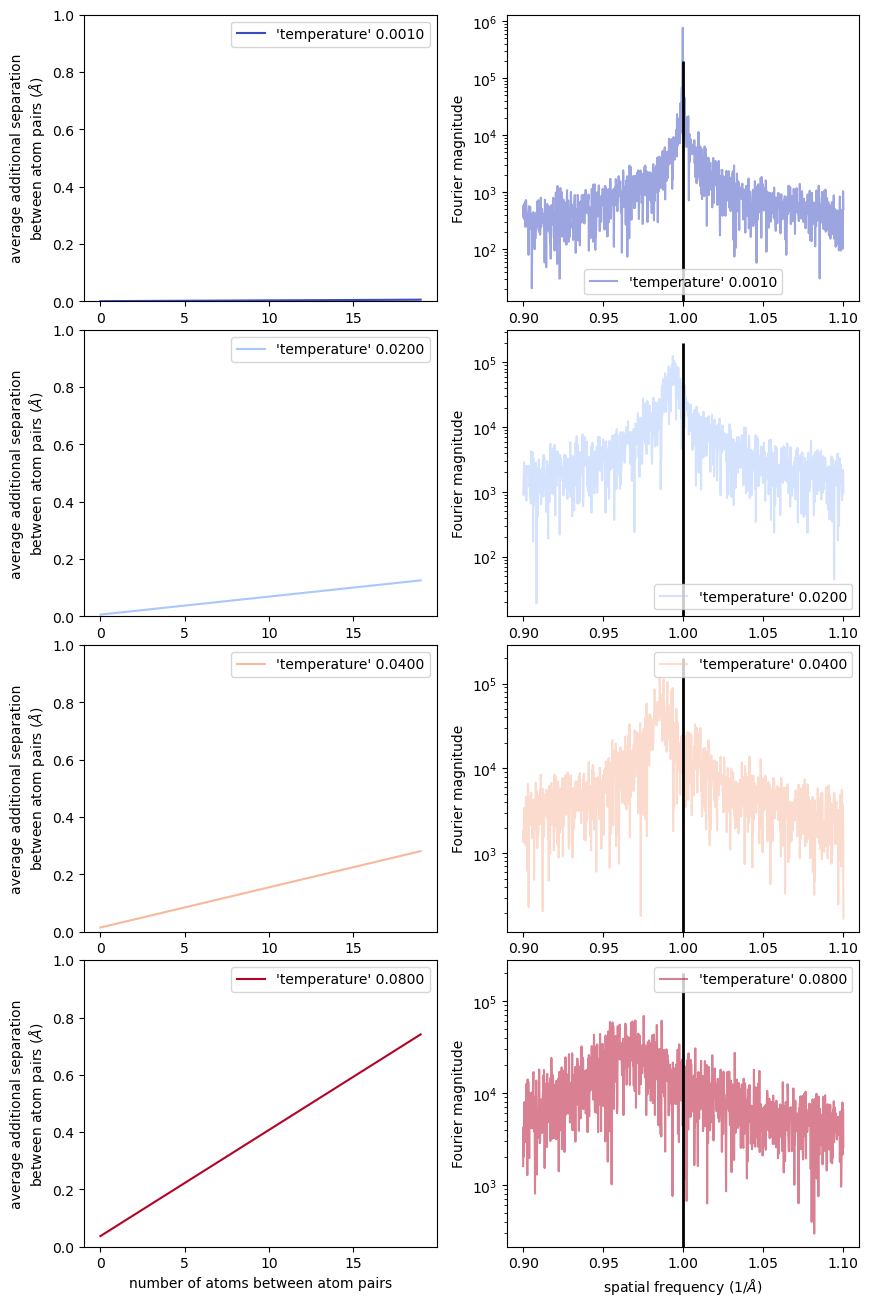

In [135]:
qs = np.linspace(0.9,1.1,1000)
temps = [0.001,0.02,0.04,0.08]
cm = plt.get_cmap('coolwarm')
colors = [cm(i) for i in np.linspace(0,1,len(temps))]
fig, axes = plt.subplots(len(temps),2, figsize=(10,4*len(temps)))
for n,t in enumerate(temps):
    steps, distances, fourier = gen_fourier_mp(t, qs)
    _ = axes[n,0].plot(distances.mean(axis=0), color=colors[n], label=f"'temperature' {t:0.4f}")
    _ = axes[n,0].set(ylim=(0,1), xlabel='number of atoms between atom pairs', ylabel=f'average additional separation\nbetween atom pairs (${{\AA}}$)')
    axes[n,0].legend()
    _ = axes[n,1].plot(qs, np.abs(fourier), color=colors[n], label=f"'temperature' {t:0.4f}", alpha=0.5)
    _ = axes[n,1].set(xlabel=f'spatial frequency (1/${{\AA}}$)', yscale='log', ylabel='Fourier magnitude')
    axes[n,1].vlines(1, 0, 2E5, 'k', lw=2)
    axes[n,1].legend()
plt.subplots_adjust(hspace=0.1, wspace=0.2)
#plt.savefig("fourier_qshift.png")

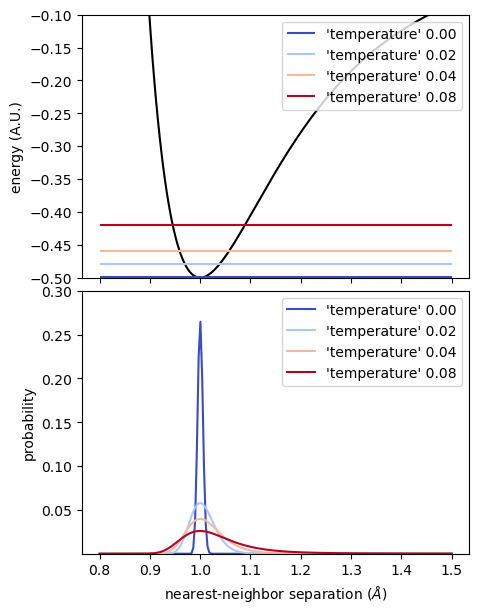

In [139]:
seps, energy, probs = gen_lj_potential(0.1, min_sep=0.8, max_sep=1.5, num_sep=200)
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True)
axes[0].plot(seps, energy, 'k-')
axes[0].set(xlabel=r'separation ($\AA$)', ylabel='energy (A.U.)', ylim=(-0.5,-0.1))

for t,c in zip(temps, colors):
    seps, energy, probs = gen_lj_potential(t, min_sep=0.8, max_sep=1.5, num_sep=200)
    axes[0].hlines(t+energy.min(), 0.8, 1.5, color=c, label=f"'temperature' {t:0.2f}")
    axes[1].plot(seps, probs, c=c, label=f"'temperature' {t:0.2f}")
    axes[1].set(xlabel=r'nearest-neighbor separation ($\AA$)', ylabel='probability', ylim=(1E-5, 3E-1))
axes[1].legend()
axes[0].legend(loc='upper right')

plt.subplots_adjust(hspace=0.05)

In [333]:
nrows, ncols = 60,60
num_atoms = nrows*ncols
steps = np.random.choice(seps, size=2*num_atoms, replace=True, p=probs).reshape(nrows,ncols,2)

In [334]:
positions = np.zeros((nrows+1, ncols+1,2))

In [335]:
positions[0] = np.vstack([np.arange(0, (ncols+1)*mean_sep, mean_sep), np.zeros(ncols+1)]).T #Lay down first row of atoms
positions[:,0] = np.vstack([np.zeros(ncols+1), np.arange(0, (ncols+1)*mean_sep, mean_sep)]).T #Lay down first column of atoms

In [336]:
for r in range(1, nrows+1):
    for c in range(1, ncols+1):
        f = np.sqrt( (positions[r-1,c,0] - positions[r,c-1,0])**2 + (positions[r-1,c,1] - positions[r,c-1,1])**2 )
        a, b = steps[r-1,c-1,0], steps[r-1,c-1,1]
        if((a*a + f*f - b*b)/(2*a*f)>1):
            print("Bad",r,c)
            break
        theta = np.arccos( (a*a + f*f - b*b)/(2*a*f) )
        eta = np.arctan2( (positions[r-1,c,0]-positions[r,c-1,0]),(positions[r,c-1,1]-positions[r-1,c,1]) )
        #print(r,c,eta,theta)
        positions[r,c,0] = positions[r,c-1,0] + a*np.sin(theta+eta) 
        positions[r,c,1] = positions[r,c-1,1] - a*np.cos(theta+eta) 

Bad 36 40
Bad 37 40
Bad 38 40
Bad 39 40
Bad 40 40
Bad 41 40
Bad 42 40
Bad 43 40
Bad 44 40
Bad 45 40
Bad 46 40
Bad 47 40
Bad 48 40
Bad 49 40
Bad 50 40
Bad 51 40
Bad 52 40
Bad 53 40
Bad 54 40
Bad 55 40
Bad 56 40
Bad 57 40
Bad 58 40
Bad 59 40
Bad 60 40


Text(0.5, 1.0, 'Left and bottom edges start out as 1D crystals.')

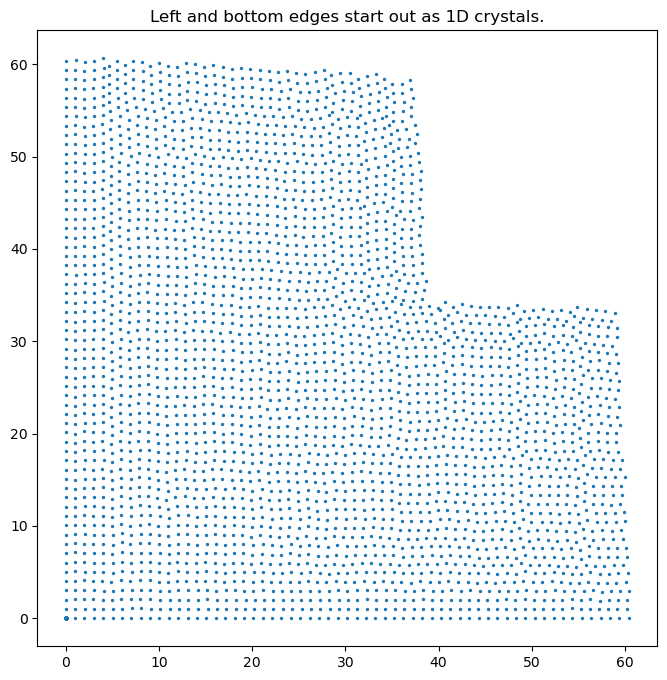

In [337]:
plt.figure(figsize=(8,8))
plt.scatter(*positions.reshape(-1,2).T, s=2)
plt.title(f'Left and bottom edges start out as 1D crystals.')

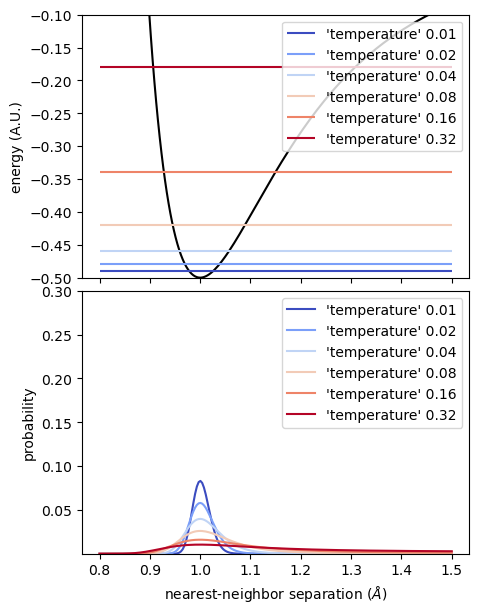

In [765]:
seps, energy, probs = gen_lj_potential(0.1, min_sep=0.8, max_sep=1.5, num_sep=200)
fig, axes = plt.subplots(2,1, figsize=(5,7), sharex=True)
axes[0].plot(seps, energy, 'k-')
axes[0].set(xlabel=r'separation ($\AA$)', ylabel='energy (A.U.)', ylim=(-0.5,-0.1))

temps = [0.01,0.02,0.04,0.08,0.16,0.32]
cm = plt.get_cmap('coolwarm')
colors = [cm(i) for i in np.linspace(0,1,len(temps))]

for t,c in zip(temps, colors):
    seps, energy, probs = gen_lj_potential(t, min_sep=0.8, max_sep=1.5, num_sep=200)
    axes[0].hlines(t+energy.min(), 0.8, 1.5, color=c, label=f"'temperature' {t:0.2f}")
    axes[1].plot(seps, probs, c=c, label=f"'temperature' {t:0.2f}")
    axes[1].set(xlabel=r'nearest-neighbor separation ($\AA$)', ylabel='probability', ylim=(1E-5, 3E-1))
axes[1].legend()
axes[0].legend(loc='upper right')

plt.subplots_adjust(hspace=0.05)

In [341]:
def compute_lj_potential(sep):
    return (0.5/sep**12 - 1/sep**6)

In [860]:
def gen_2d_square_lattice(a, nr, nc):
    xs = np.arange(0, nr*a, a).astype('float')
    ys = np.arange(0, nc*a, a).astype('float')
    return np.meshgrid(xs,ys)

def neighbor_list_for_2d_square_lattice(nr, nc):
    arr = []
    for i in range(nr):
        for j in range(nc):
            l_arr = []
            if i > 0:     l_arr += [[i-1, j]]
            if i < nr-1 : l_arr += [[i+1, j]]
            if j > 0:     l_arr += [[i, j-1]]
            if j < nc-1:  l_arr += [[i, j+1]]
            arr += [np.asarray(l_arr)]
    return np.asarray(arr, dtype=object).reshape(nr, nc, -1)

def compute_nn_energies(x, y, i, j, xs, ys, nn_list):
    rs, cs = nn_list[i,j][0].T
    nn_xs = xs[rs,cs]
    nn_ys = ys[rs,cs]
    seps = np.sqrt( (nn_xs-x)**2 + (nn_ys-y)**2 )
    return compute_lj_potential(seps) + 0.5

def compute_nn_distances(i, j, xs, ys, nn_list):
    rs, cs = nn_list[i,j][0].T
    x,y = xs[i,j].copy(), ys[i,j].copy()
    nn_xs = xs[rs,cs]
    nn_ys = ys[rs,cs]
    seps = np.sqrt( (nn_xs-x)**2 + (nn_ys-y)**2 )
    return seps

def perturb_atom(i, j, xs, ys, nn_list, rands, mag=0.05, t=.01):
    x,y = xs[i,j].copy(), ys[i,j].copy() 
    r = mag*rands[0]
    theta = 2*np.pi*rands[1]
    x += r*np.cos(theta)
    y += r*np.sin(theta)
    prob = np.exp(-np.sum(compute_nn_energies(x,y,i,j,xs,ys,nn_list))/t)
    #print(prob)
    if rands[2] < prob:
        xs[i,j] = x
        ys[i,j] = y

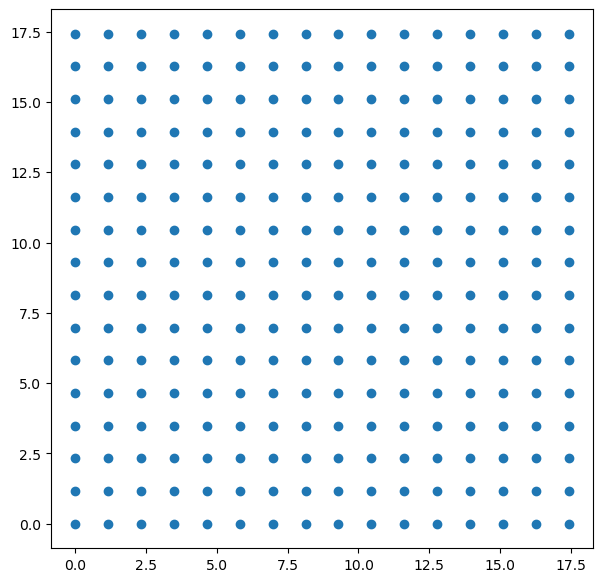

In [868]:
nr,nc=15,15
temp = 0.16

min_sep, max_sep, num_sep = 0.5, 2.0, 100
seps, energy, probs = gen_lj_potential(temp, min_sep=min_sep, max_sep=max_sep, num_sep=num_sep)

mean_sep = (seps*probs).sum()

nn = neighbor_list_for_2d_square_lattice(nr,nc)
xs, ys = gen_2d_square_lattice(mean_sep, nr,nc)
org_xs, org_ys = xs.copy(), ys.copy()
plt.figure(figsize=(7,7))
plt.scatter(org_xs, org_ys)

In [869]:
n_turns = 20000000
rands = np.random.rand(n_turns, 3)
fix_boundary = True

if fix_boundary:
    rand_r = np.random.choice(range(1,nr-1), n_turns, replace=True)
    rand_c = np.random.choice(range(1,nc-1), n_turns, replace=True)
else:
    rand_r = np.random.choice(range(nr), n_turns, replace=True)
    rand_c = np.random.choice(range(nc), n_turns, replace=True)

for ind in tqdm(range(n_turns)):
    perturb_atom(rand_r[ind], rand_c[ind], xs, ys, nn, rands[ind], t=temp)

100%|██████████████████████████████████████████████████████████████████████████| 20000000/20000000 [14:05<00:00, 23647.66it/s]


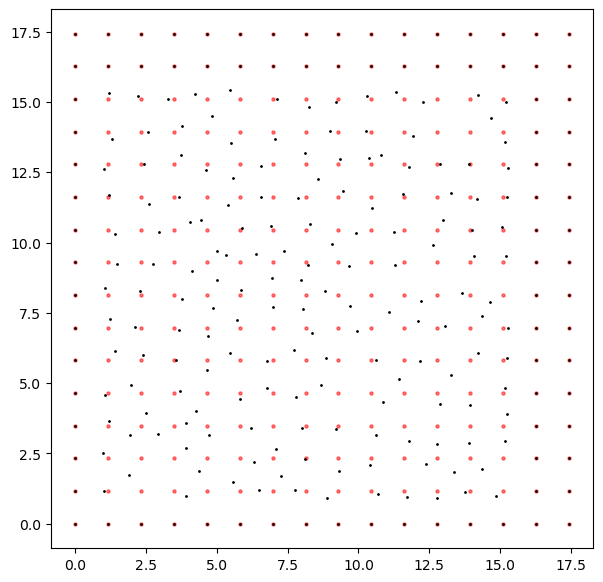

In [870]:
plt.figure(figsize=(7,7))
plt.scatter(org_xs, org_ys, c='r', s=5, alpha=0.5)
plt.scatter(xs, ys, c='k', s=1)

In [871]:
if fix_boundary:
    distances = np.hstack([compute_nn_distances(i, j, xs, ys, nn) for i in range(1,nr-1) for j in range(1,nc-1)])
else:
    distances = np.hstack([compute_nn_distances(i, j, xs, ys, nn) for i in range(nr) for j in range(nc)])

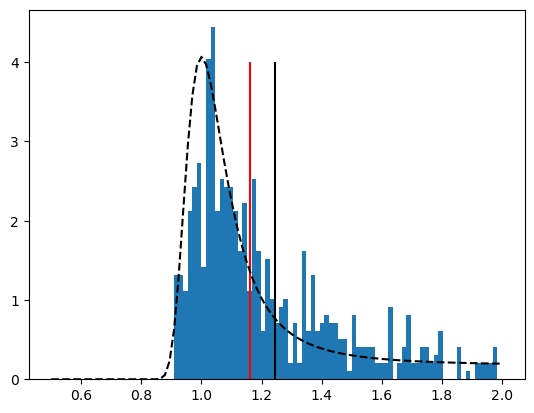

In [872]:
_ = plt.hist(distances, bins=np.linspace(min_sep, max_sep, num_sep), density=True)
plt.vlines(mean_sep, 0, 4, 'r')
plt.vlines(distances.mean(), 0, 4,  'k')
plt.plot(seps, probs/((max_sep-min_sep)/num_sep), 'k--')